**Problem 2. Edge Detection**

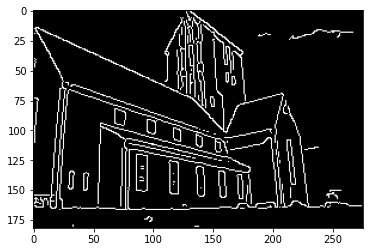

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

def edge_detection (img, sigma, low_threshold, high_threshold):
    """
    :param img: input grayscale image
    :param sigma: Gaussian filter width
    :param low_threshold: low thresholds
    :param high_threshold: high threshold
    """
    gaussian = gaussian_filter(img, sigma)
    mag_value, slope = gradient(gaussian)
    non_max_sup = non_maximum_suppression(mag_value, slope)
    thre, low, high = threshold(non_max_sup, low_threshold, high_threshold)
    
    return hysteresis(thre, low, high)   
    
# Noice reduction with gaussian kernel
def gaussian_filter(img, sigma):
    width = 7    # default with value 7
    dim = (2 * sigma ** 2) 
    
    # get the 1D kernel
    kernel = np.zeros(shape=(width,1))
    
    # apply the gaussian formula to each pixel based on (x,y) coordinates 
    for i in range (-width//2, width//2 + 1, 1):
        value = np.exp(-(i ** 2) / dim) / 2.0 * math.pi * (sigma**2)
        kernel[int(i + width//2)] = value
    
    # normalize the value
    kernel_y = kernel / kernel.sum()
    kernel_x = kernel_y.transpose()
    
    # Gaussian filter in horizontal convolution
    kx = cv2.filter2D(img, -1, kernel_x)
    # Gaussian filter in vertical convolution
    gaussian = cv2.filter2D(kx, -1, kernel_y)
    
    return gaussian

# Compute magnitude of gradient
# M(x,y) = sqrt(Ix^2 + Iy^2)
def gradient(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float64)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float64)
    
    Ix = cv2.filter2D(img, -1, Kx)
    Iy = cv2.filter2D(img, -1, Ky)
    
    # comput the value of magnitude
    mag_value = np.hypot(Ix, Iy)
    # compute the slope of the gradient
    slope = np.arctan2(Iy, Ix)
    
    return (mag_value, slope)

# Non-maximum suppression
# Check if pixel is local maximum along gradient direction
def non_maximum_suppression(img, theta):
    R = img.shape[0]
    G = img.shape[1]
    non_max_sup = np.zeros(img.shape)
    
    # quantizing the theta to 180 degrees
    theta = theta * 180. / np.pi
    theta[theta < 0] += 180
    
    # check interploated pixels p and r
    for i in range(1, R - 1):
        for j in range(1, G - 1):
            temp = 0
            # 0 - 22.5 and 157.5 - 180
            if (0 <= theta[i,j] < 22.5) or (157.5 <= theta[i,j] <= 180):
                temp = max(img[i, j+1], img[i, j-1])
            # 22.5 - 67.5
            elif (22.5 <= theta[i,j] < 67.5):
                temp = max(img[i+1, j-1], img[i-1, j+1])
            # 67.5 - 112.5
            elif (67.5 <= theta[i,j] < 112.5):
                temp = max(img[i+1, j], img[i-1, j])
            # 112.5 - 157.5
            elif (112.5 <= theta[i,j] < 157.5):
                temp = max(img[i-1, j-1], img[i+1, j+1])
            # keep the pixel if it is maximum
            if (img[i,j] > temp):
                non_max_sup[i,j] = img[i,j]
            else:
                non_max_sup[i,j] = 0
                
    non_max_sup = (non_max_sup/np.max(non_max_sup)) * 255
    return non_max_sup

# Double thresholding
# Edges with strength < L are discarded
# Edges with strength > H are kept
def threshold(img, low_threshold, high_threshold):
    R = img.shape[0]
    G = img.shape[1]
    thre = np.zeros(img.shape)
    
    low = 255/3    # default with value 255/3
    high = 255     # default with value 255
    
    high_r, high_g = np.where(img > high_threshold)
    # edges with strengths < H will be set to zero
    zeros_r, zeros_g = np.where(img < low_threshold)
    # set edges to low for next step if its strengths is between L and H
    low_r, low_g = np.where((img <= high_threshold) & (img >= low_threshold))
    
    thre[high_r, high_g] = high
    thre[low_r, low_g] = low
    thre[zeros_r, zeros_g] = 0
    
    return (thre, low, high)


# Edge tracking by hysteresis
# Edge p with strength between L and H is kept only if there is path of edges with strength > connecting p to an edge of strength > H
def hysteresis(img, low, high):
    R = img.shape[0]
    G = img.shape[1]  
    
    for i in range(1, R - 1):
        for j in range(1, G - 1):
            # if current edge is set as low by last process
            if (img[i,j] == low):
                # check all its neighbours whether containing strong strength
                if ((img[i-1, j+1] == high) or (img[i, j+1] == high) or (img[i+1, j+1] == high) 
                    or (img[i-1, j] == high) or (img[i+1, j] == high) or (img[i-1, j-1] == high) 
                    or (img[i, j-1] == high) or (img[i+1, j-1] == high)):
                    
                    img[i, j] = high
                # discard the edge if all its neighbours are also discarded
                else:
                    img[i, j] = 0
    return img

if __name__ == '__main__':
    img = plt.imread("image1.jfif")
    #plt.imshow(img)
    #plt.show()
    
    img = img.mean(axis=-1)

    # (img, sigma, low_threshold, high_threshold)
    plt.imshow(edge_detection (img, 1, 10, 30), cmap = 'gray')
    plt.show()    


**Problem 3. Corner Detection**

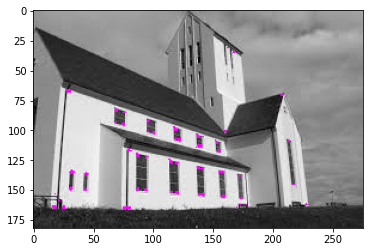

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

# Noice reduction with gaussian kernel
def gaussian_filter(img, sigma):
    width = 7    # default with value 7
    dim = (2 * sigma ** 2) 
    
    # get the 1D kernel
    kernel = np.zeros(shape=(width,1))
    
    # apply the gaussian formula to each pixel based on (x,y) coordinates 
    for i in range (-width//2, width//2 + 1, 1):
        value = np.exp(-(i ** 2) / dim) / 2.0 * math.pi * (sigma**2)
        kernel[int(i + width//2)] = value
    
    # normalize the value
    kernel_y = kernel / kernel.sum()
    kernel_x = kernel_y.transpose()
    
    # Gaussian filter in horizontal convolution
    kx = cv2.filter2D(img, -1, kernel_x)
    # Gaussian filter in vertical convolution
    gaussian = cv2.filter2D(kx, -1, kernel_y)
    
    return gaussian

def gradient(img):
    # 5 x 5 sobel convolution kernel
    Gx = np.array(
        [
            [2, 2, 4, 2, 2],
            [1, 1, 2, 1, 1],
            [0 ,0 ,0 ,0 ,0],
            [-1,-1,-2,-1,-1],
            [-2,-2,-4,-2,-2]
        ]
    )
    Gy = np.array(
        [
            [2, 1, 0, -1, -2],
            [2, 1, 0, -1, -2],
            [4, 2, 0, -2, -4],
            [2, 1, 0, -1, -2],
            [2, 1, 0, -1, -2]
        ]
    )
    
    Ix = cv2.filter2D(img, -1, Gx)
    Iy = cv2.filter2D(img, -1, Gy)
    
    return (Ix, Iy)

# calculate score for each point
def harris(ix2, iy2, ix_iy, k):
    result = []
    for i in range(ix2.shape[0]):
        result.append([])
        for j in range(ix2.shape[1]):
            M = np.array(
                [
                    [ix2[i,j],ix_iy[i,j]],
                    [ix_iy[i,j],iy2[i,j]]
                ]
            )
            result[-1].append(np.linalg.det(M)-k*(np.trace(M)**2))

    return np.array(result)

# compare and make change on the image
def change_on_image(img,score):
    decide_value = 34 * math.fabs(score.mean())
    # scored the point if its score is higher than the average
    scored = score > decide_value
    
    final_img = img.copy()
    
    # purple the points
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if scored[i,j]:
                final_img[i,j] = [255, 0 ,255]

    return final_img

if __name__ == '__main__':
    
    orignal_img = plt.imread("image1.jfif")
    #plt.imshow(orignal_img)
    #plt.show()
    
    img = orignal_img.mean(axis=-1)

    Ix, Iy = gradient(img)

    ix2 = Ix * Ix
    iy2 = Iy * Iy
    ix_iy = Ix * Iy

    ix2 = gaussian_filter(ix2, 1)
    iy2 = gaussian_filter(iy2, 1)
    ix_iy = gaussian_filter(ix_iy, 1)

    score = harris(ix2, iy2, ix_iy, 0.05)

    final_img = change_on_image(orignal_img,score)

    plt.imshow(final_img.astype(np.uint8))
    plt.show()